In [126]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
%matplotlib inline

In [127]:
import os
print os.getcwd()

/Users/leahgaeta/DAT-SM-18/projects/final-project/04-notebook-rough-draft


Many in the baseball and sports worlds know of Bill James as the spearhead of the field of sabermetrics -- a subject in which baseball is analyzed using statistics. He is credited with creating a formula for predicting expected win percentage, known as the "Pythagorean Thereom" of baseball. His simple formula deals simply with just a team's total runs scored (RS) and total runs allowed (RA), and is written as follows:

EXP(W%) = (RS)2 / [(RS)2 + (RA)2]

The exponent has been adjusted season to season, but the 2 is a good and simple approximation.

While James' formula is a very useful tool for teams, I want to see if I can go beyond that. Such as, **HOW** are baseball teams winning? The goal of this project is to predict win percentage based on play on the field, and to explore which offensive and defensive metrics are the most important variables to winning games. Team statistics and information from the 1960 - 2015 seasons will be used for this analysis.

In [128]:
df_team = pd.read_csv("../team_data.csv")
print df_team.head()

   year league_id team_id franchise_id div_id  rank    g  ghome   w   l  \
0  1960        AL     BAL          BAL    NaN     2  154     77  89  65   
1  1960        AL     BOS          BOS    NaN     7  154     77  65  89   
2  1960        AL     CHA          CHW    NaN     3  154     77  87  67   
3  1960        NL     CHN          CHC    NaN     7  156     79  60  94   
4  1960        NL     CIN          CIN    NaN     6  154     77  67  87   

       ...         dp    fp               name              park  attendance  \
0      ...        172  0.98  Baltimore Orioles  Memorial Stadium     1187849   
1      ...        156  0.97     Boston Red Sox    Fenway Park II     1129866   
2      ...        175  0.98  Chicago White Sox     Comiskey Park     1644460   
3      ...        133  0.97       Chicago Cubs     Wrigley Field      809770   
4      ...        155  0.97    Cincinnati Reds     Crosley Field      663486   

   bpf  ppf  team_id_br  team_id_lahman45  team_id_retro  
0   99   

In [129]:
df_team.count()

year                1462
league_id           1462
team_id             1462
franchise_id        1462
div_id              1288
rank                1462
g                   1462
ghome               1462
w                   1462
l                   1462
div_win             1260
wc_win               624
lg_win              1434
ws_win              1434
r                   1462
ab                  1462
h                   1462
double              1462
triple              1462
hr                  1462
bb                  1462
so                  1462
sb                  1462
cs                  1462
hbp                  480
sf                   480
ra                  1462
er                  1462
era                 1462
cg                  1462
sho                 1462
sv                  1462
ipouts              1462
ha                  1462
hra                 1462
bba                 1462
soa                 1462
e                   1462
dp                  1462
fp                  1462


In [130]:
#can see that there are missing values, specifically in hbp and sf columns
#these will be needed later for the analysis so will need to fill the missing null values with zeros

df_team.fillna(value = 0, inplace = True)

#need to check now
df_team.count()

year                1462
league_id           1462
team_id             1462
franchise_id        1462
div_id              1462
rank                1462
g                   1462
ghome               1462
w                   1462
l                   1462
div_win             1462
wc_win              1462
lg_win              1462
ws_win              1462
r                   1462
ab                  1462
h                   1462
double              1462
triple              1462
hr                  1462
bb                  1462
so                  1462
sb                  1462
cs                  1462
hbp                 1462
sf                  1462
ra                  1462
er                  1462
era                 1462
cg                  1462
sho                 1462
sv                  1462
ipouts              1462
ha                  1462
hra                 1462
bba                 1462
soa                 1462
e                   1462
dp                  1462
fp                  1462


In [131]:
#list of column names
list(df_team)

['year',
 'league_id',
 'team_id',
 'franchise_id',
 'div_id',
 'rank',
 'g',
 'ghome',
 'w',
 'l',
 'div_win',
 'wc_win',
 'lg_win',
 'ws_win',
 'r',
 'ab',
 'h',
 'double',
 'triple',
 'hr',
 'bb',
 'so',
 'sb',
 'cs',
 'hbp',
 'sf',
 'ra',
 'er',
 'era',
 'cg',
 'sho',
 'sv',
 'ipouts',
 'ha',
 'hra',
 'bba',
 'soa',
 'e',
 'dp',
 'fp',
 'name',
 'park',
 'attendance',
 'bpf',
 'ppf',
 'team_id_br',
 'team_id_lahman45',
 'team_id_retro']

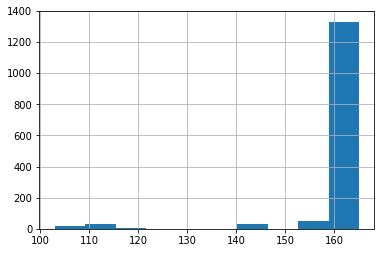

In [132]:
#does every team play the same numnber of games?
#variable 'g' is number of games played
df_team['g'].hist()

One can see that not every team from each year plays the same number of games. This could be due to rain-outs, tie-break games, and strike-shortened seasons. Therefore, a new column titled 'wp' for Win Percentage must be made.  This is ultimately what one wants to predict from the model. 

In [133]:
#to calculate win percentage 'wp', take the number of games won 'w' divided by total number of games played 'g'

df_team['wp'] = df_team['w']/df_team['g']
print df_team['wp'].head()

0    0.577922
1    0.422078
2    0.564935
3    0.384615
4    0.435065
Name: wp, dtype: float64


For the analysis, offensive & defensive metrics will be the variables used to predict winning percentage. The offensive metrics include Runs (r), Singles (single = h - double - triple - hr), Doubles (double), Triples (triple), Home Runs (hr), Walks (bb), and Strikeouts (so). A new column will need to be made for total number of Singles (single). To account for the varying number of games played by each team during the seasons, the offensive metrics need to be adjusted. 

Basically, I'm going to create my own stats now.

Total number of At Bats (ab) does not take into account Walks (bb), and therefore a new column for Plate Appearances (pa) must be made. The offensive metrics will then become Runs per PA (rppa), Singles per PA (sppa), Doubles per PA (dppa), Triples per PA (tppa), Home Runs per PA (hrppa), Walks per PA (bbppa), and Strikeouts per PA (kppa). New columns will need to be made for these variables.

In [134]:
#make a new column for Singles
#to calculate singles, take the number of hits (h) and subtract doubles (double), triples (triple), and home runs (hr)

df_team['singles'] = df_team['h'] - df_team['double'] - df_team['triple'] - df_team['hr']
print df_team['singles'].head()

0     945
1     969
2    1010
3     913
4     914
Name: singles, dtype: int64


In [135]:
#make a new column for Plate Appearances
#plate appearances can be calculated by adding At bats (ab), Walks (bb), Hit by Pitch (hbp), Sacrifice Hit (sh), 
#Sacrifice Fly (sf), and Times Reached on Defensive Interference together.
#This Plate Appearance (pa) calculation does not include sac hit (only sac fly, sf) since there is no data for sh
#or times reached on defensive indifference, such as catcher's interference

df_team['pa'] = df_team['ab'] + df_team['bb'] + df_team['hbp'] + df_team['sf']
print df_team['pa'].head()

0    5766.0
1    5785.0
2    5758.0
3    5842.0
4    5801.0
Name: pa, dtype: float64


In [136]:
#now the offensive metrics need to be adjusted
#make new columns for Runs per PA (rppa), Singles per PA (sppa), Doubles per PA (dppa), 
#Triples per PA (tppa), Home Runs per PA (hrppa), Walks per PA (bbppa), and Strikeouts per PA (kppa)

df_team['rppa'] = df_team['r']/df_team['pa']
print df_team['rppa'].head()

df_team['sppa'] = df_team['singles']/df_team['pa']
print df_team['sppa'].head()

df_team['dppa'] = df_team['double']/df_team['pa']
print df_team['dppa'].head()

df_team['tppa'] = df_team['triple']/df_team['pa']
print df_team['tppa'].head()

df_team['hrppa'] = df_team['hr']/df_team['pa']
print df_team['hrppa'].head()

df_team['bbppa'] = df_team['bb']/df_team['pa']
print df_team['bbppa'].head()

df_team['kppa'] = df_team['so']/df_team['pa']
print df_team['kppa'].head()

0    0.118280
1    0.113742
2    0.128691
3    0.108524
4    0.110326
Name: rppa, dtype: float64
0    0.163892
1    0.167502
2    0.175408
3    0.156282
4    0.157559
Name: sppa, dtype: float64
0    0.035727
1    0.040449
2    0.042028
3    0.036460
4    0.039648
Name: dppa, dtype: float64
0    0.005723
1    0.005532
2    0.006600
3    0.008216
4    0.006895
Name: tppa, dtype: float64
0    0.021332
1    0.021435
2    0.019451
3    0.020370
4    0.024134
Name: hrppa, dtype: float64
0    0.103365
1    0.098531
2    0.098472
3    0.090894
4    0.088261
Name: bbppa, dtype: float64
0    0.138918
1    0.137943
2    0.112539
3    0.153543
4    0.147906
Name: kppa, dtype: float64


Again, offensive & defensive metrics will be the variables used to predict winning percentage in this analysis. Now that the offensive metrics are done, there needs to also be adjustments for the defensive metrics. The defensive metrics used will be Opponents Runs Scored (ra), Earned Runs Allowed (er), Hits Allowed (ha), Homeruns Allowed (hra), Walks Allowed (bba), Strikeouts by Pitcher (soa), Double Plays (dp), and Fielding Percentage (fp)*. Since Hits Allowed (ha) includes Homeruns Allowed (hra), a new column will need to be made for Non HR Hits Allowed (nhrha). All of these defensive metrics will be adjusted for Per Out Pitched (ipouts) to account for the different number of games played, excluding Fielding Percentage (fp) as it is already a percentage.  New columns will need to be made for these variables: Opponents Runs Scored per Out Pitched (rapop), Earned Runs Allowed per Out Pitched (erpop), Non HR Hits Allowed per Out Pitched (nhrhpop), Homeruns Allowed per Out Pitched (hrpop), Walks Allowed per Out Pitched (bbpop), Strikeouts by Pitcher per Out Pitched (kpop), and Double Plays per Out Pitched (dppop)*. Again, Fielding Percentage (fp) does not need to be adjusted.

*Fielding Percentage will be taken into account for the analysis since Errors (e) are included in the Fielding Percentage calculation. FP = (Putous + Assists)/Total Chances (Putous + Assists + Errors). Higher FP is indicative of less errors committed by the defense.

*For Double Plays per Out Pitched (dppop), Double Plays (dp) will need to be divided by 2 since a double play produces two outs

In [137]:
#make a new column for Non HR Hits Allowed (nhrha)
#take the total number of Hits Allowed (ha) subtracted by the total number of Homeruns Allowed (hra)

df_team['nhrha'] = df_team['ha'] - df_team['hra']
print df_team['nhrha'].head()

0    1105
1    1313
2    1211
3    1241
4    1283
Name: nhrha, dtype: int64


In [138]:
#now the defensive metrics need to be adjusted for Outs Pitched (ipouts) and make new columns

#Opponents Runs Scored per Out Pitched (rapop)
df_team['rapop'] = df_team['ra']/df_team['ipouts']
print df_team['rapop'].head()

#Earned Runs Allowed per Out Pitched (erpop) 
df_team['erpop'] = df_team['er']/df_team['ipouts']
print df_team['erpop'].head()

#Non HR Hits Allowed per Out Pitched (nhrhpop)
df_team['nhrhpop'] = df_team['nhrha']/df_team['ipouts']
print df_team['nhrhpop'].head()

#Homeruns Allowed per Out Pitched (hrpop)
df_team['hrpop'] = df_team['hra']/df_team['ipouts']
print df_team['hrpop'].head()

#Walks Allowed per Out Pitched (bbpop)
df_team['bbpop'] = df_team['bba']/df_team['ipouts']
print df_team['bbpop'].head()

#Strikeouts by Pitcher per Out Pitched (kpop)
df_team['kpop'] = df_team['soa']/df_team['ipouts']
print df_team['kpop'].head()

#Double Plays per Out Pitched (dppop)
df_team['dppop'] = df_team['dp']/df_team['ipouts']
print df_team['dppop'].head()

0    0.146909
1    0.189811
2    0.148926
3    0.184498
4    0.165947
Name: rapop, dtype: float64
0    0.130424
1    0.171198
2    0.133237
3    0.161198
4    0.148201
Name: erpop, dtype: float64
0    0.267879
1    0.321577
2    0.292300
3    0.295055
4    0.307674
Name: nhrhpop, dtype: float64
0    0.028364
1    0.031105
2    0.030654
3    0.036139
4    0.032134
Name: hrpop, dtype: float64
0    0.133818
1    0.142052
2    0.128651
3    0.134332
4    0.105995
Name: bbpop, dtype: float64
0    0.190303
1    0.187852
2    0.167753
3    0.191393
4    0.177458
Name: kpop, dtype: float64
0    0.041697
1    0.038207
2    0.042240
3    0.031621
4    0.037170
Name: dppop, dtype: float64


In [139]:
#now that the variables have all been adjusted, it's time to create a new clean data frame for the analysis

#identify columns to keep 
cols_to_keep = ['year', 'team_id', 'wp', 'rppa', 'sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa', 'rapop', 'erpop', 'nhrhpop', 'hrpop', 'bbpop', 'kpop', 'dppop', 'fp']

data = df_team[cols_to_keep]
print data.head()

   year team_id        wp      rppa      sppa      dppa      tppa     hrppa  \
0  1960     BAL  0.577922  0.118280  0.163892  0.035727  0.005723  0.021332   
1  1960     BOS  0.422078  0.113742  0.167502  0.040449  0.005532  0.021435   
2  1960     CHA  0.564935  0.128691  0.175408  0.042028  0.006600  0.019451   
3  1960     CHN  0.384615  0.108524  0.156282  0.036460  0.008216  0.020370   
4  1960     CIN  0.435065  0.110326  0.157559  0.039648  0.006895  0.024134   

      bbppa      kppa     rapop     erpop   nhrhpop     hrpop     bbpop  \
0  0.103365  0.138918  0.146909  0.130424  0.267879  0.028364  0.133818   
1  0.098531  0.137943  0.189811  0.171198  0.321577  0.031105  0.142052   
2  0.098472  0.112539  0.148926  0.133237  0.292300  0.030654  0.128651   
3  0.090894  0.153543  0.184498  0.161198  0.295055  0.036139  0.134332   
4  0.088261  0.147906  0.165947  0.148201  0.307674  0.032134  0.105995   

       kpop     dppop    fp  
0  0.190303  0.041697  0.98  
1  0.187852  0

In [140]:
#take a deeper look into the data
data.describe()

,year,wp,rppa,sppa,dppa,tppa,hrppa,bbppa,kppa,rapop,erpop,nhrhpop,hrpop,bbpop,kpop,dppop,fp
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000
mean,1989.630643,0.499614,0.116899,0.163269,0.042169,0.005637,0.023885,0.086799,0.160198,0.164023,0.147989,0.295573,0.033562,0.121673,0.224309,0.034655,0.977182
std,15.783454,0.070841,0.013122,0.010717,0.006239,0.001732,0.006129,0.010616,0.025420,0.022480,0.021745,0.019226,0.007679,0.016229,0.036834,0.004252,0.006115
min,1960.000000,0.248447,0.079452,0.126672,0.025892,0.001786,0.007866,0.059227,0.095462,0.104547,0.090828,0.225182,0.013468,0.078058,0.132184,0.021863,0.960000
25%,1976.250000,0.450617,0.108128,0.155686,0.037397,0.004420,0.019408,0.079190,0.142844,0.148171,0.132598,0.282323,0.027797,0.109999,0.198405,0.031626,0.970000
50%,1991.000000,0.500000,0.116624,0.163159,0.042749,0.005483,0.023732,0.086248,0.158380,0.162331,0.146591,0.295419,0.033482,0.120788,0.222428,0.034594,0.980000
75%,2003.000000,0.549383,0.125647,0.170385,0.046744,0.006607,0.027881,0.094039,0.176032,0.178495,0.161837,0.308822,0.038933,0.132021,0.248505,0.037503,0.981000
max,2015.000000,0.716049,0.158225,0.202749,0.059253,0.012781,0.042444,0.122436,0.256990,0.256750,0.236266,0.354556,0.056099,0.182495,0.329171,0.048986,0.991000


In [141]:
#look into any possible correlations by creating a correlation matrix
data.corr()

,year,wp,rppa,sppa,dppa,tppa,hrppa,bbppa,kppa,rapop,erpop,nhrhpop,hrpop,bbpop,kpop,dppop,fp
year,1.000000,0.004688,0.290045,-0.400151,0.704140,-0.369120,0.381546,-0.067761,0.604322,0.321341,0.413875,0.138923,0.477559,0.026108,0.655339,-0.047535,0.708609
wp,0.004688,1.000000,0.513726,0.090871,0.162617,0.038024,0.303660,0.307515,-0.142105,-0.542703,-0.491744,-0.459358,-0.234575,-0.430494,0.164247,-0.143158,0.209708
rppa,0.290045,0.513726,1.000000,0.026013,0.587209,-0.041519,0.710277,0.409389,-0.031673,0.362997,0.403242,0.209893,0.468299,0.094329,0.148931,0.121502,0.254637
sppa,-0.400151,0.090871,0.026013,1.000000,-0.251221,0.309173,-0.465655,-0.206226,-0.673678,-0.107303,-0.144511,0.156364,-0.321158,-0.047466,-0.441444,0.138298,-0.359982
dppa,0.704140,0.162617,0.587209,-0.251221,1.000000,-0.151905,0.436445,0.014929,0.289223,0.394990,0.464327,0.245387,0.467604,0.076046,0.422313,0.043074,0.522441
tppa,-0.369120,0.038024,-0.041519,0.309173,-0.151905,1.000000,-0.336645,-0.154311,-0.266852,-0.129299,-0.164898,0.016335,-0.254388,-0.065037,-0.319628,0.029961,-0.286554
hrppa,0.381546,0.303660,0.710277,-0.465655,0.436445,-0.336645,1.000000,0.241093,0.342920,0.349626,0.396902,0.062024,0.586896,0.096965,0.363172,0.040069,0.366438
bbppa,-0.067761,0.307515,0.409389,-0.206226,0.014929,-0.154311,0.241093,1.000000,-0.081369,0.070572,0.070395,-0.000452,0.083783,0.141584,-0.043487,0.008817,-0.022139
kppa,0.604322,-0.142105,-0.031673,-0.673678,0.289223,-0.266852,0.342920,-0.081369,1.000000,0.163342,0.212077,-0.083593,0.362368,0.028171,0.645418,-0.139427,0.431028
rapop,0.321341,-0.542703,0.362997,-0.107303,0.394990,-0.129299,0.349626,0.070572,0.163342,1.000000,0.984661,0.743124,0.750297,0.581750,-0.002285,0.267597,0.069797


One can see that there are especially strong correlations between Runs per PA (rppa) & HR per PA (hrppa), Opponents Runs Scored per OP (rapop) & Earned Runs per OP (erpop) & Homeruns Allowed per OP (hrpop).  This makes sense because a Homerun is always going to score at least one run, and up to four runs depending on how many baserunners there are during the Plate Appearance. Opponents Runs Scored per OP and Earned Runs per OP are also going to be strongly correlated since an earned run will always count towards an opponent's total runs scored. It therefore makes sense to drop 'rppa', 'rapop', and 'erpop' from the dataframe, but keep 'hrppa' and 'hrpop'.  This will allow for a better analysis to win percentage.

In [142]:
#now need to create another new data frame for the analysis by dropping 'rppa', 'rapop', and 'erpop'

#identify new columns to keep 
new_cols_to_keep = ['year', 'team_id', 'wp', 'sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa', 'nhrhpop', 'hrpop', 'bbpop', 'kpop', 'dppop', 'fp']

adj_data = df_team[new_cols_to_keep]
print adj_data.head()

   year team_id        wp      sppa      dppa      tppa     hrppa     bbppa  \
0  1960     BAL  0.577922  0.163892  0.035727  0.005723  0.021332  0.103365   
1  1960     BOS  0.422078  0.167502  0.040449  0.005532  0.021435  0.098531   
2  1960     CHA  0.564935  0.175408  0.042028  0.006600  0.019451  0.098472   
3  1960     CHN  0.384615  0.156282  0.036460  0.008216  0.020370  0.090894   
4  1960     CIN  0.435065  0.157559  0.039648  0.006895  0.024134  0.088261   

       kppa   nhrhpop     hrpop     bbpop      kpop     dppop    fp  
0  0.138918  0.267879  0.028364  0.133818  0.190303  0.041697  0.98  
1  0.137943  0.321577  0.031105  0.142052  0.187852  0.038207  0.97  
2  0.112539  0.292300  0.030654  0.128651  0.167753  0.042240  0.98  
3  0.153543  0.295055  0.036139  0.134332  0.191393  0.031621  0.97  
4  0.147906  0.307674  0.032134  0.105995  0.177458  0.037170  0.97  


In [143]:
#make a new correlation matrix
adj_data.corr()

,year,wp,sppa,dppa,tppa,hrppa,bbppa,kppa,nhrhpop,hrpop,bbpop,kpop,dppop,fp
year,1.000000,0.004688,-0.400151,0.704140,-0.369120,0.381546,-0.067761,0.604322,0.138923,0.477559,0.026108,0.655339,-0.047535,0.708609
wp,0.004688,1.000000,0.090871,0.162617,0.038024,0.303660,0.307515,-0.142105,-0.459358,-0.234575,-0.430494,0.164247,-0.143158,0.209708
sppa,-0.400151,0.090871,1.000000,-0.251221,0.309173,-0.465655,-0.206226,-0.673678,0.156364,-0.321158,-0.047466,-0.441444,0.138298,-0.359982
dppa,0.704140,0.162617,-0.251221,1.000000,-0.151905,0.436445,0.014929,0.289223,0.245387,0.467604,0.076046,0.422313,0.043074,0.522441
tppa,-0.369120,0.038024,0.309173,-0.151905,1.000000,-0.336645,-0.154311,-0.266852,0.016335,-0.254388,-0.065037,-0.319628,0.029961,-0.286554
hrppa,0.381546,0.303660,-0.465655,0.436445,-0.336645,1.000000,0.241093,0.342920,0.062024,0.586896,0.096965,0.363172,0.040069,0.366438
bbppa,-0.067761,0.307515,-0.206226,0.014929,-0.154311,0.241093,1.000000,-0.081369,-0.000452,0.083783,0.141584,-0.043487,0.008817,-0.022139
kppa,0.604322,-0.142105,-0.673678,0.289223,-0.266852,0.342920,-0.081369,1.000000,-0.083593,0.362368,0.028171,0.645418,-0.139427,0.431028
nhrhpop,0.138923,-0.459358,0.156364,0.245387,0.016335,0.062024,-0.000452,-0.083593,1.000000,0.295801,0.255401,-0.300893,0.368382,-0.087206
hrpop,0.477559,-0.234575,-0.321158,0.467604,-0.254388,0.586896,0.083783,0.362368,0.295801,1.000000,0.313602,0.297933,0.117525,0.366220


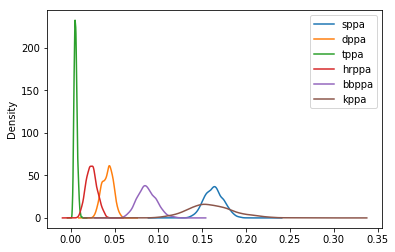

In [144]:
#now need to look into the distributions of each independent variable that is an offensive metric
#first need to create another new data frame for offensive metrics only

#identify offensive columns to keep 
off_cols_to_keep = ['sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa']

off_data = df_team[off_cols_to_keep]

off_data.plot(kind='density')

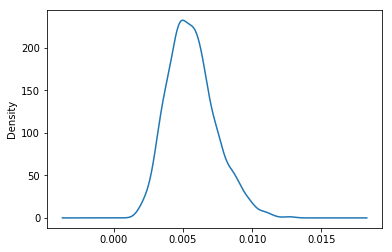

In [145]:
#hard to see the distribution of triples per pa (tppa), so can take another look without the other variables
off_data['tppa'].plot(kind='density')

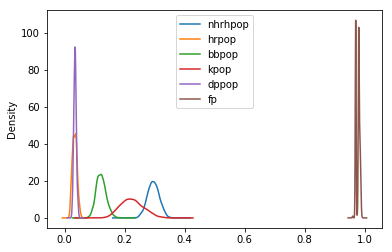

In [146]:
#can now do the same for independent variables that are defensive metrics
#have to create another new data frame for defensive metrics only

#identify defensive columns to keep 
def_cols_to_keep = ['nhrhpop', 'hrpop', 'bbpop', 'kpop', 'dppop', 'fp']

def_data = df_team[def_cols_to_keep]

def_data.plot(kind='density')

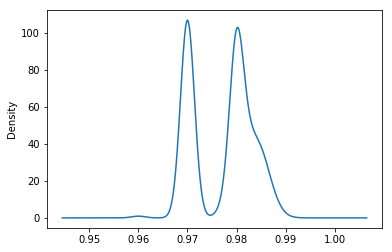

In [147]:
#hard to see the distribution of fielding percentage (fp), so can take a closer look
def_data['fp'].plot(kind='density')

It's important to note that it's not a normal distribution of fielding percentage.

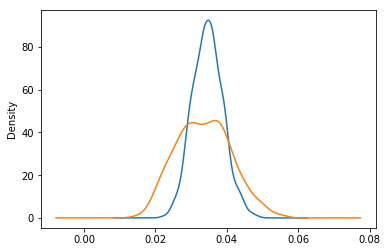

In [148]:
#also hard to see the distributions of dppop and hrpop so can take a closer look

def_data['dppop'].plot(kind='density')

def_data['hrpop'].plot(kind='density')

It looks as if dppop and hrpop both have normal distributions.

Analysis Plan: Using the offensive and defensive predictor variables, a multilinear regression model will be created to explore the association between these variables and win percentage.  

Null hypothesis: There is no association between the offensive predictor variables and win percentage. There is also no association between the defensive predictor variables and win percentage. (p-values > 0.05)

Hypothesis: There is an association between the offensive predictor variables and win percentage.  There is also an association between the defensive predictor variables and win percentage. (p-values < 0.05)

Data Dictionary: describes the final dataset used for the analysis


Variable | Description | Type of Variable
---| ---| ---
year| Year data collected | Categorical
team_id | Team from which data was collected | Categorical 
wp | Win Percentage | Continuous
sppa | Singles per Plate Appearance (offense) | Continuous
dppa | Doubles per Plate Appearance (offense) | Continuous
tppa | Triples per Plate Appearance (offense) | Continuous
hrppa | Homeruns per Plate Appearance (offense) | Continuous
bbppa | Walks per Plate Appearance (offense) | Continuous
kppa | Strikeouts per Plate Appearance (offense) | Continuous
nhrhpop | Non Homerun Hits Against per Out Pitched (defense) | Continuous
hrpop | Homeruns Against per Out Pitched (defense) | Continuous
bbpop | Walks Against per Out Pitched (defense) | Continuous
kpop | Strikeouts by Pitcher per Out Pitched (defense) | Continuous
dppop | Double Plays Made per Out Pitched (defense) | Continuous
fp | Fielding Percentage (defense) | Continuous

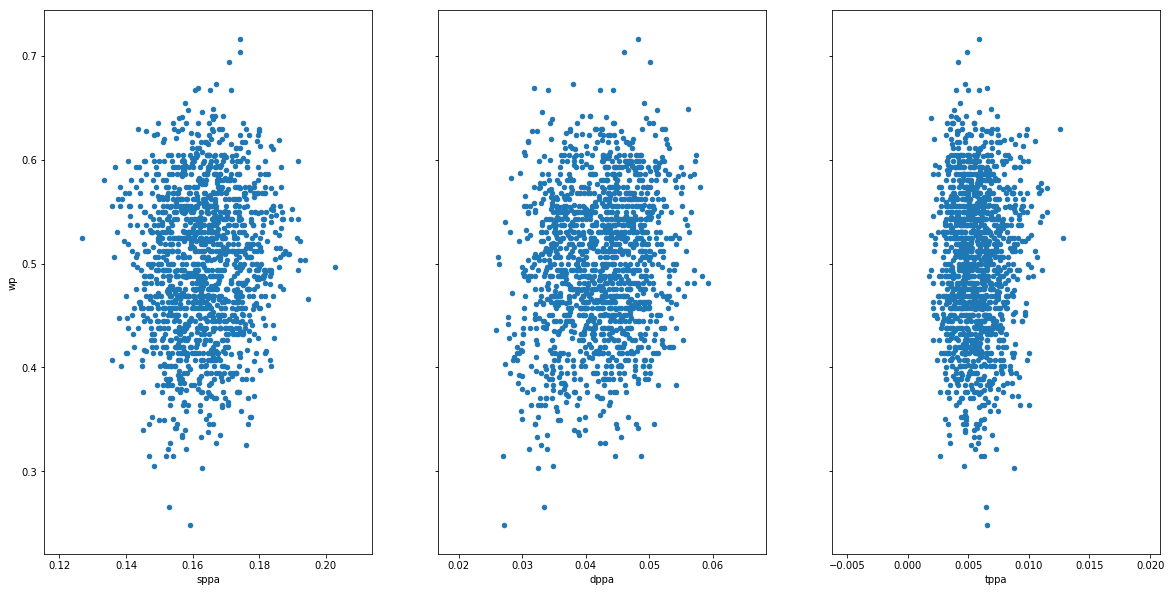

In [149]:
#now want to look at scatter plots for each offensive predictor variable and the response variable, win percentage (wp)

fig, axs = plt.subplots(1, 3, sharey=True)
#singles per plate appearance (sppa) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='sppa', y='wp', ax=axs[0], figsize=(20, 10))

#doubles per plate appearance (dppa) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='dppa', y='wp', ax=axs[1])

#triples per plate appearance (tppa) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='tppa', y='wp', ax=axs[2])

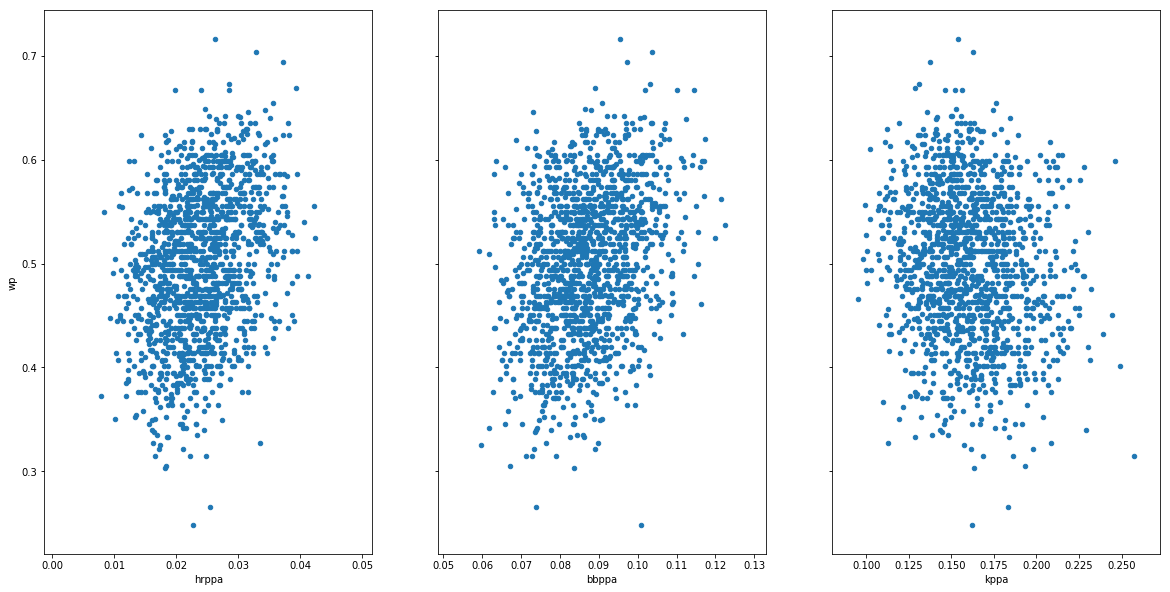

In [150]:
#more scatter plots for the other three offensive predictor variables and the response variable, win percentage (wp)

fig, axs = plt.subplots(1, 3, sharey=True)

#homeruns per plate appearance (hrppa) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='hrppa', y='wp', ax=axs[0], figsize=(20, 10))

#walks per plate appearance (bbppa) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='bbppa', y='wp', ax=axs[1])

#strikeouts per plate appearance (kppa) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='kppa', y='wp', ax=axs[2])

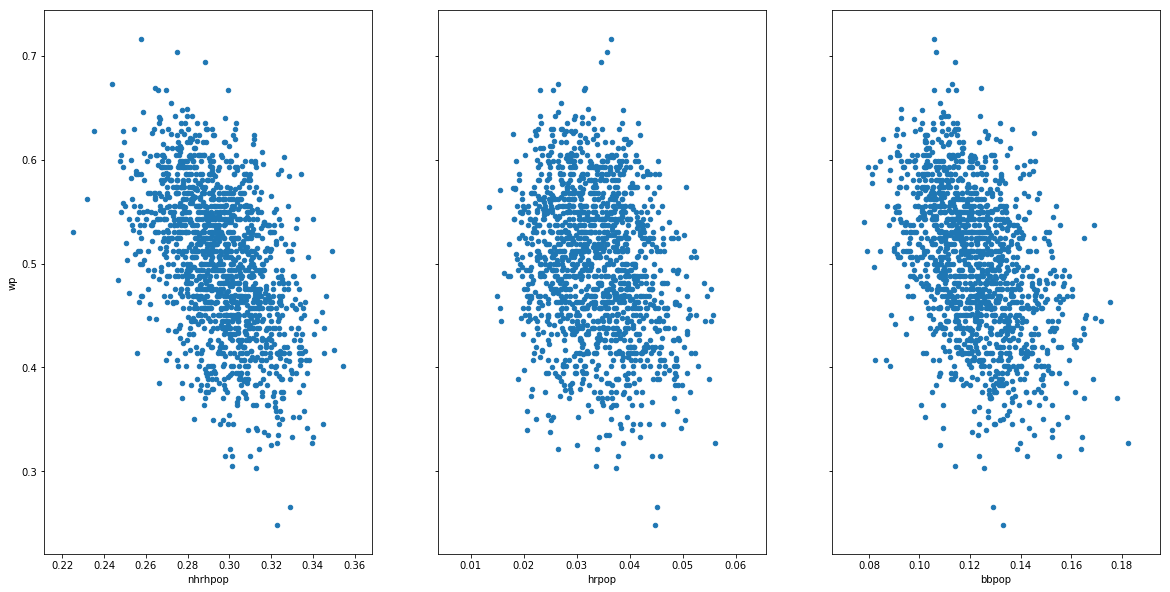

In [151]:
#now need to look at scatter plots for each defensive predictor variable and the response variable, win percentage (wp)

fig, axs = plt.subplots(1, 3, sharey=True)
#non homerun hits per out pitched (nhrhpop) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='nhrhpop', y='wp', ax=axs[0], figsize=(20, 10))

#homeruns per out pitched (hrpop) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='hrpop', y='wp', ax=axs[1])

#walks per out pitched (bbpop) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='bbpop', y='wp', ax=axs[2])

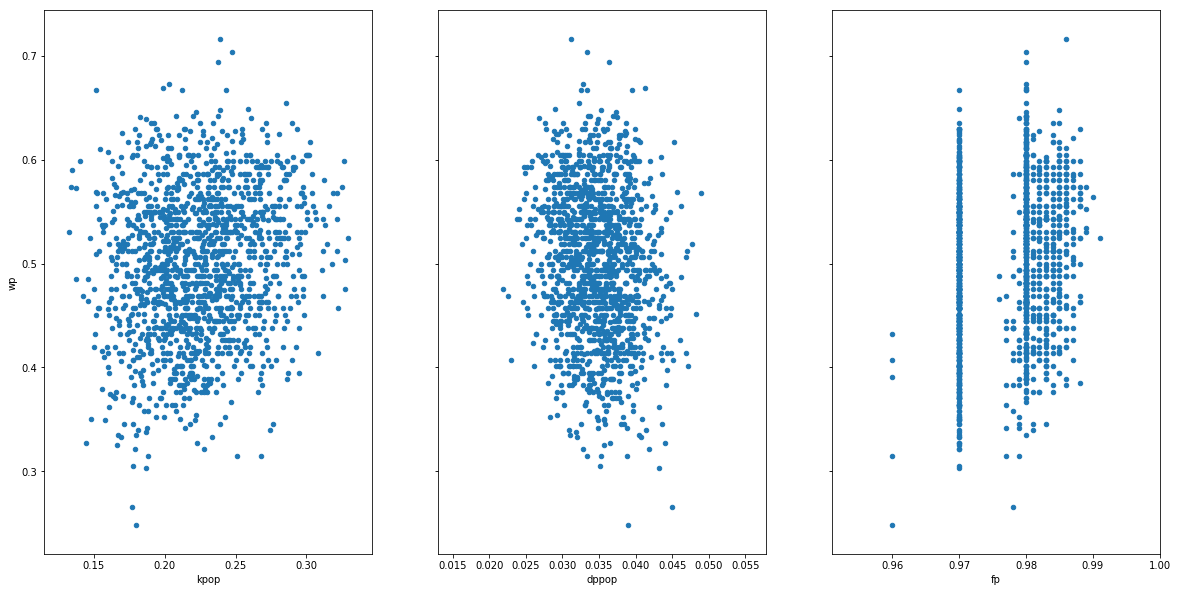

In [152]:
#last few scatter plots for the other three defensive predictor variable and the response variable, win percentage (wp)

fig, axs = plt.subplots(1, 3, sharey=True)
#strikeouts per out pitched (kpop) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='kpop', y='wp', ax=axs[0], figsize=(20, 10))

#double plays per out pitched (dppop) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='dppop', y='wp', ax=axs[1])

#fielding percentage (fp) vs. win percentage (wp)
adj_data.plot(kind='scatter', x='fp', y='wp', ax=axs[2])

From these plots, we want to further explore whether there is an association between these offensive and defensive predictor variables and the outcome (win percentage). And if there is, how strong is the relationships? Do either of these metrics have more of an impact on win percentage than others?

In [153]:
import statsmodels.formula.api as sm

#multiple linear regression model for offensive metrics
model_off = sm.ols(formula='wp ~ sppa + dppa + tppa + hrppa + bbppa + kppa', data=adj_data).fit()

model_off.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wp   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     84.10
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           1.51e-90
Time:                        11:25:47   Log-Likelihood:                 2014.0
No. Observations:                1462   AIC:                            -4014.
Df Residuals:                    1455   BIC:                            -3977.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1112      0.056     -1.997      0.046      -0.220      -0.002
sppa           1.7960      0.225      7.994      0.000       1.355       2.237
dppa           1.0943      0.290      3.772      0.000       0.525       1.663
tppa           5.1077      1.005      5.083      0.000       3.136       7.079
hrppa          4.4256      0.331     13.367      0.000       3.776       5.075
bbppa          1.8955      0.166     11.436      0.000       1.570       2.221
kppa          -0.1722      0.091     -1.888      0.059      -0.351       0.007
==============================================================================
Omnibus:                        8.886   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.309
Skew:                          -0.093   Prob(JB):                       0.0259
Kurtosis:                       2.707   Cond. No.                         649.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this model taking into account offensive metrics only, there is statistical significance (p < 0.05) that there is a relationship between Win Percentage and the following offsensive metrics: Singles per PA (sppa), Doubles per PA (dppa), Triples per PA (tppa), Homeruns per PA (hrppa), and Walks per PA (bbppa). However, there is no statistical significance (p > 0.05) of a relationship between Strikeouts per PA (kppa) and Win Percentage.  From this model one can also see that these predictor variables are all positively associated with Win Percentage, except for Strikeouts per Plate Appearance (this is determined based on the signs of the coefficients). The R2 is equal to 0.258.

In [154]:
#multiple linear regression model for defensive metrics
model_def = sm.ols(formula='wp ~ nhrhpop + hrpop + bbpop + kpop + dppop + fp', data=adj_data).fit()

model_def.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wp   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     130.2
Date:                Thu, 18 Jan 2018   Prob (F-statistic):          5.18e-132
Time:                        11:25:47   Log-Likelihood:                 2110.6
No. Observations:                1462   AIC:                            -4207.
Df Residuals:                    1455   BIC:                            -4170.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0058      0.301     -3.338      0.001      -1.597      -0.415
nhrhpop       -1.3249      0.093    -14.248      0.000      -1.507      -1.142
hrpop         -1.0335      0.245     -4.224      0.000      -1.513      -0.554
bbpop         -1.3155      0.103    -12.710      0.000      -1.519      -1.112
kpop           0.0193      0.056      0.348      0.728      -0.090       0.128
dppop          1.3148      0.409      3.211      0.001       0.512       2.118
fp             2.0896      0.314      6.660      0.000       1.474       2.705
==============================================================================
Omnibus:                        4.940   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.542
Skew:                          -0.086   Prob(JB):                        0.103
Kurtosis:                       2.789   Cond. No.                         456.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this model taking into account defensive metrics only, there is statistical significance (p < 0.05) that there is a relationship between Win Percentage (wp)  and the following defensive metrics: Non HR Hit per Out Pitched (nhrhpop), Homeruns per Out Pitched (hrpop), Walks per Out Pitched (bbpop), Double Plays per Out Pitched (dppop), and Fielding Percentage (fp). However, there is no statistical significance (p > 0.05) of a relationship between Strikeouts per Out Pitched (kpop) and Win Percentage. From this model one can also see that these predictor variables are all negatively associated with Win Percentage, except for Strikeouts per Out Pitched, Double Plays per Out Pitched, and Fielding Percentage (this is determined based on the signs of the coefficients). The R2 is equal to 0.349. Now we want to see what the model would look like with all metrics combined.

In [155]:
#multiple linear regression model for both offensive and defensive metrics
model_all = sm.ols(formula='wp ~ sppa + dppa + tppa + hrppa + bbppa + kppa + nhrhpop + hrpop + bbpop + kpop + dppop + fp', data=adj_data).fit()

model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wp   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     527.5
Date:                Thu, 18 Jan 2018   Prob (F-statistic):               0.00
Time:                        11:25:47   Log-Likelihood:                 3024.9
No. Observations:                1462   AIC:                            -6024.
Df Residuals:                    1449   BIC:                            -5955.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1116      0.178     -6.233      0.000      -1.461      -0.762
sppa           2.8448      0.117     24.417      0.000       2.616       3.073
dppa           3.1966      0.180     17.758      0.000       2.843       3.550
tppa           4.7954      0.520      9.218      0.000       3.775       5.816
hrppa          6.6850      0.186     35.893      0.000       6.320       7.050
bbppa          2.3057      0.084     27.427      0.000       2.141       2.471
kppa          -0.0284      0.055     -0.520      0.603      -0.135       0.079
nhrhpop       -1.6456      0.055    -30.178      0.000      -1.753      -1.539
hrpop         -3.6023      0.152    -23.701      0.000      -3.900      -3.304
bbpop         -1.2502      0.056    -22.179      0.000      -1.361      -1.140
kpop           0.0081      0.037      0.216      0.829      -0.065       0.082
dppop          0.5812      0.222      2.623      0.009       0.147       1.016
fp             1.3990      0.181      7.720      0.000       1.044       1.754
==============================================================================
Omnibus:                        0.896   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.849
Skew:                          -0.058   Prob(JB):                        0.654
Kurtosis:                       3.021   Cond. No.                         961.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model performs with an r-squared of 0.814, with all p-values of the coefficients being significant (p < 0.05) except for Strikeouts per Plate Appearance (kppa) and Strikeouts per Out Pitched (kpop). 

Based on the coefficients, this OLS Regression Model tells us that more extra base hits per plate appearance are important for producing wins, as is not giving up homeruns (hrpop coefficient = -3.6023). Of the 4 types of hits, Homeruns per PA are most impactful on producing wins (coefficient = 6.6850), followed by Triples per PA (coefficient = 4.7954), Doubles per PA (coefficient = 3.1966), and Singles per PA (coefficient = 2.8448) in that order. It is interesting to note that Walks per PA (coefficient = 2.3057) has a different and smaller coefficient than Singles per PA (coefficient = 2.8448) when they both put the hitter on first base. It can also be seen that walking a hitter (bbpop coefficient = -1.2502) is almost as impactful as giving up a non-homerun hit (nhrhpop coefficient = -1.6456). In addition, while the magnitude of Fielding Percentage's coefficient isn't as relatively large as the other features' (coefficient = 1.3990), it does suggest that good fielding/defense is important for winning. Also worth noting, despite the statistical insignifance, Strikeouts per PA or Strikeouts per Out Pitched have small coefficient magnitudes, which can be interpreted as not being as impactful in producing wins. This suggests that a hitter who strikes out a lot but can also hit homeruns is important to his team winning! It is important to mention that only the offensive metrics can be compared to each other (since they are all per PA) and only the defensive metrics can be compared to each (since they are all per Out Pitched, except for Fielding Percentage).

From here, further attempts to improve the model will be made.

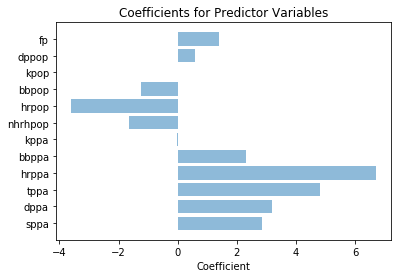

In [156]:
#let's look at the coefficients visually
coef = ('sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa', 'nhrhpop', 'hrpop', 'bbpop', 'kpop', 'dppop', 'fp')
y_pos = np.arange(len(coef))
performance = [2.8448,3.1966,4.7954,6.6850,2.3057,-0.0284,-1.6456,-3.6023,-1.2502,0.0081,0.5812,1.3990]
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, coef)
plt.xlabel('Coefficient')
plt.title('Coefficients for Predictor Variables')
 
plt.show()

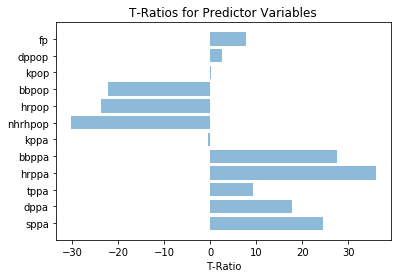

In [157]:
#now let's look at the t-ratios visually
trat = ('sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa', 'nhrhpop', 'hrpop', 'bbpop', 'kpop', 'dppop', 'fp')
y_pos = np.arange(len(trat))
performance = [24.417,17.758,9.218,35.893,27.427,-0.520,-30.178,-23.701,-22.179,0.216,2.623,7.720]
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, trat)
plt.xlabel('T-Ratio')
plt.title('T-Ratios for Predictor Variables')
 
plt.show()

Again, from these bar charts, the biggest takeaway is that homeruns and walks really matter while strikeouts don't! For both offensive production and defensive prevention of these happening! Remember, only the offensive stats can be compared to each other and only the defensive stats can be compared to each.

In [158]:
#see the model using scikit learn and see if it can be refined from there
from sklearn import linear_model, metrics, cross_validation
modeldata = adj_data[['sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa', 'nhrhpop', 'hrpop', 'bbpop', 'kpop', 'dppop', 'fp']]
y = adj_data.wp

In [186]:
#look into cross validation now
kf = cross_validation.KFold(len(modeldata), n_folds=7, shuffle=True)

mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    cv_lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], cv_lm.predict(modeldata.iloc[test_index])))
    scores.append(cv_lm.score(modeldata, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]
    
print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.00101954564292
R2: 0.813336621591
Model 2
MSE: 0.000740949550997
R2: 0.813471679308
Model 3
MSE: 0.000961243195858
R2: 0.813386386393
Model 4
MSE: 0.000958964317422
R2: 0.813505502037
Model 5
MSE: 0.00100312801891
R2: 0.813346558001
Model 6
MSE: 0.000949623089753
R2: 0.813236014154
Model 7
MSE: 0.00106567365047
R2: 0.813445287342
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.000957018209477
Mean of R2 for all folds: 0.813389721261


To trade off potential bias error for generalized error, a 7-fold cross validation was done and the mean of the R2 is still 0.814. In addition, any cv value of k yields the same mean R2. It is therefore likely that the model is not overfit and that regularization of the model won't improve it further, as seen below with the MSE and R2 values from Lasso and Ridge regressions.

In [160]:
#now see what happens to the model when regularization is taken into effect with Lasso and Ridge regressions

LinM = linear_model.LinearRegression().fit(modeldata, y)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(y, LinM.predict(modeldata))
print 'OLS R2:', LinM.score(modeldata, y)

LasM = linear_model.Lasso().fit(modeldata, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, LasM.predict(modeldata))
print 'Lasso R2:', LasM.score(modeldata, y)

RidM = linear_model.Ridge().fit(modeldata, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, RidM.predict(modeldata))
print 'Ridge R2:', RidM.score(modeldata, y)

~~~ OLS ~~~
OLS MSE:  0.000934075100654
OLS R2: 0.813743255675
~~~ Lasso ~~~
Lasso MSE:  0.00501498672728
Lasso R2: 0.0
~~~ Ridge ~~~
Ridge MSE:  0.00357933323559
Ridge R2: 0.286272640341


In the first Ordinary Least Squares model, it is the same model as before with an R2 of 0.814. This was done for reference to compare the Lasso and Ridge fits. In the Lasso model, the mean squared error (MSE) increases slightly and the R2 goes to 0. This won't be looked into further. In the Ridge model, the MSE also slightly increases and the R2 decreases to 0.286. This also won't be looked into further.

In [161]:
#look into KNN regression
from sklearn.neighbors import KNeighborsRegressor
neigh_1 = KNeighborsRegressor(n_neighbors=2, weights='uniform')
knnrM_1 = neigh_1.fit(modeldata, y)
print knnrM_1

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')


In [162]:
print "~~~ KNN Reg ~~~"
print 'KNN Reg MSE: ', metrics.mean_squared_error(y, knnrM_1.predict(modeldata))
print 'KNN Reg R2:', knnrM_1.score(modeldata, y)

~~~ KNN Reg ~~~
KNN Reg MSE:  0.000996797349437
KNN Reg R2: 0.801236293605


In [163]:
neigh_2 = KNeighborsRegressor(n_neighbors=3, weights='uniform')
knnrM_2 = neigh_2.fit(modeldata, y)
print "~~~ KNN Reg ~~~"
print 'KNN Reg MSE: ', metrics.mean_squared_error(y, knnrM_2.predict(modeldata))
print 'KNN Reg R2:', knnrM_2.score(modeldata, y)

~~~ KNN Reg ~~~
KNN Reg MSE:  0.00128925675934
KNN Reg R2: 0.742919208076


With KNN Regression, the R2 decreases when k increases. When k nearest neighbors is 2, we get the best performance with a KNN Regression. This produces a R2 = 0.801 and the MSE increases very slightly (by ~0.00006), so it still looks like the OLS model thus far has the best performance. Will now look into a random forest regressor.

In [164]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()
regrM = regr.fit(modeldata, y)
print regrM

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [165]:
print "~~~ RF Reg ~~~"
print 'RF Reg MSE: ', metrics.mean_squared_error(y, regrM.predict(modeldata))
print 'RF Reg R2:', regrM.score(modeldata, y)

~~~ RF Reg ~~~
RF Reg MSE:  0.000329380632896
RF Reg R2: 0.934320736862


In [166]:
modeldata.columns.values

array(['sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa', 'nhrhpop',
       'hrpop', 'bbpop', 'kpop', 'dppop', 'fp'], dtype=object)

In [167]:
pd.DataFrame({'variable name': modeldata.columns.values, 'importance scores': regrM.feature_importances_}).sort_values('importance scores', ascending=False)

,importance scores,variable name
6,0.210907,nhrhpop
8,0.180349,bbpop
4,0.135402,bbppa
3,0.124757,hrppa
0,0.083225,sppa
1,0.071838,dppa
7,0.065611,hrpop
5,0.036725,kppa
2,0.031710,tppa
10,0.025642,dppop


In [168]:
regrM.feature_importances_

array([ 0.08322495,  0.0718376 ,  0.03170974,  0.12475684,  0.13540151,
        0.036725  ,  0.21090652,  0.06561099,  0.18034864,  0.02013088,
        0.02564189,  0.01370543])

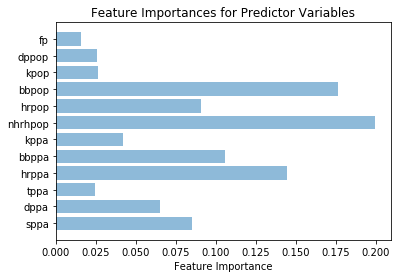

In [169]:
#now let's plot the random forest regression feature importances visually!
fimp = ('sppa', 'dppa', 'tppa', 'hrppa', 'bbppa', 'kppa', 'nhrhpop', 'hrpop', 'bbpop', 'kpop', 'dppop', 'fp')
y_pos = np.arange(len(fimp))
performance = [0.08496011,0.06480991,0.02442617,0.1441522 ,0.10576651,0.04204998,0.19927957,0.0905883,0.17654221,0.02620549,0.02573646,0.01548309]
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, fimp)
plt.xlabel('Feature Importance')
plt.title('Feature Importances for Predictor Variables')
 
plt.show()

Again, walks and homeruns are key! With Random Forest Regression, the feature importances can actually all be compared to each other, despite having different denominators. From this chart above, the 2 most important features are defensive: Non HR hits per OP (nhrhpop) and Walks per OP (bbpop). It's important to note that Non HR hits per OP is not broken down into Singles, Doubles, or Triples, as that data is not available from this set. The next 2 most important features are offensive: HR per PA (hrppa) and Walks per PA (bbppa). The next 2 features after these are Homeruns given up per OP (hrpop) and Singles per PA (sppa). This all intuitively makes sense and is comparable to the OLS Regression model from before. Homeruns and Walks are important predictors for win percentage and offense & defense both matter! From the Random Forest Regression model, it actually looks as those defense may be of more importance than offense in terms of predicting win perentage, but it can easily be seen that certainly both contribute to the prediction. Again, note that strikeouts per PA or per OP are not as of much importance. So if a team wants to sign a hitter that hits a lot of homeruns, walks a bunch, and strikes out many times ... he can be worth signing!

It is also interesting to see that the importance of Triples per PA (tppa) is comparably lower than what the coefficient suggested for the OLS model before.

In [188]:
new_kf = cross_validation.KFold(len(modeldata), n_folds=6, shuffle=True)

mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in new_kf:
    cv_rfr = regr.fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], cv_rfr.predict(modeldata.iloc[test_index])))
    scores.append(cv_rfr.score(modeldata, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]
    
print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.00177841725666
R2: 0.88315370136
Model 2
MSE: 0.00194873079246
R2: 0.875404403937
Model 3
MSE: 0.00180533762091
R2: 0.876294112597
Model 4
MSE: 0.00197278213033
R2: 0.878375717147
Model 5
MSE: 0.00194352932682
R2: 0.877170019361
Model 6
MSE: 0.00194849251269
R2: 0.875331542768
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.00189954827331
Mean of R2 for all folds: 0.877621582862


The performance of the Random Forest Regression (6-Fold Cross Validation) is the best model so far! The R2 is 0.878 and the MSE is 0.0019.

It is worth noting that the more folds done, the better the R2. In addition, adjusting the Random Forest Regression parameters to more trees and changing the random state for example, lead to higher R2's, which is likely due to overfitting of the data. Therefore the function was run as "auto."

In [171]:
from sklearn.cross_validation import cross_val_score
new_scores = cross_val_score(regr, modeldata, y, scoring='r2')
print('CV R2 {}, Average R2 {}'.format(new_scores, new_scores.mean()))

CV R2 [ 0.53500529  0.56961418  0.57938345], Average R2 0.561334307507


Just because, I want to see if I can make a very simple model predicting simply the number of wins, instead of win percentage. None of the data will be formatted into per Plate Appearances (PA) or per Out Pitched (OP). Simply just the raw data from the data set. This only occured to me now to try it.

In [172]:
model_test = sm.ols(formula='w ~ singles + double + triple + hr + bb + so + nhrha + hra + bba + soa + dp + fp', data=df_team).fit()

model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      w   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     429.7
Date:                Thu, 18 Jan 2018   Prob (F-statistic):               0.00
Time:                        11:25:50   Log-Likelihood:                -4643.1
No. Observations:                1462   AIC:                             9312.
Df Residuals:                    1449   BIC:                             9381.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -107.6451     33.754     -3.189      0.001    -173.857     -41.433
singles        0.0828      0.003     30.594      0.000       0.077       0.088
double         0.0362      0.005      6.731      0.000       0.026       0.047
triple         0.1599      0.016      9.805      0.000       0.128       0.192
hr             0.1627      0.006     28.385      0.000       0.151       0.174
bb             0.0514      0.002     21.949      0.000       0.047       0.056
so             0.0033      0.002      2.048      0.041       0.000       0.006
nhrha         -0.0472      0.002    -20.199      0.000      -0.052      -0.043
hra           -0.1616      0.007    -23.975      0.000      -0.175      -0.148
bba           -0.0450      0.002    -18.055      0.000      -0.050      -0.040
soa            0.0108      0.002      6.862      0.000       0.008       0.014
dp             0.0507      0.010      5.237      0.000       0.032       0.070
fp           129.9018     34.567      3.758      0.000      62.096     197.708
==============================================================================
Omnibus:                        0.749   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.688   Jarque-Bera (JB):                0.821
Skew:                          -0.043   Prob(JB):                        0.663
Kurtosis:                       2.923   Cond. No.                     7.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It looks as though it's not as great of a model, as the R2 decreases to 0.781, though all of the variables do have significance (p < 0.05). Just simply wanted to test it out. So far I like the earlier models more, especially since it can help predict win percentage even half way through a season by adjusting the data into "per plate appearance" and "per out pitched" versus just the raw number of homeruns hit for example. This could help teams make offensive or defensive adjustments if need be throughout the season. It could also help organizations finalize their approach at the trade deadline when deciding which players to trade and trade for.

In addition, I'm realizing that win percentage is a number between 0 and 1. I'm curious if I should therefore do a logistic regression, even though I'm not predicting one of two outcomes. Let's see what happens.

In [173]:
#logistic regression model
logit_data = adj_data.copy()

#manually add the intercept
logit_data['intercept'] = 1.0

print logit_data.head()

   year team_id        wp      sppa      dppa      tppa     hrppa     bbppa  \
0  1960     BAL  0.577922  0.163892  0.035727  0.005723  0.021332  0.103365   
1  1960     BOS  0.422078  0.167502  0.040449  0.005532  0.021435  0.098531   
2  1960     CHA  0.564935  0.175408  0.042028  0.006600  0.019451  0.098472   
3  1960     CHN  0.384615  0.156282  0.036460  0.008216  0.020370  0.090894   
4  1960     CIN  0.435065  0.157559  0.039648  0.006895  0.024134  0.088261   

       kppa   nhrhpop     hrpop     bbpop      kpop     dppop    fp  intercept  
0  0.138918  0.267879  0.028364  0.133818  0.190303  0.041697  0.98        1.0  
1  0.137943  0.321577  0.031105  0.142052  0.187852  0.038207  0.97        1.0  
2  0.112539  0.292300  0.030654  0.128651  0.167753  0.042240  0.98        1.0  
3  0.153543  0.295055  0.036139  0.134332  0.191393  0.031621  0.97        1.0  
4  0.147906  0.307674  0.032134  0.105995  0.177458  0.037170  0.97        1.0  


In [174]:
train_cols = logit_data.columns[3:]

In [175]:
train_cols

Index([u'sppa', u'dppa', u'tppa', u'hrppa', u'bbppa', u'kppa', u'nhrhpop',
       u'hrpop', u'bbpop', u'kpop', u'dppop', u'fp', u'intercept'],
      dtype='object')

In [176]:
logit_data['wp'].head()

0    0.577922
1    0.422078
2    0.564935
3    0.384615
4    0.435065
Name: wp, dtype: float64

In [177]:
#fit logistic regression model
logit = sm.Logit(logit_data['wp'], logit_data[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.676964
         Iterations 5


In [178]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                     wp   No. Observations:                 1462
Model:                          Logit   Df Residuals:                     1449
Method:                           MLE   Df Model:                           12
Date:                Thu, 18 Jan 2018   Pseudo R-squ.:                 0.02335
Time:                        11:25:50   Log-Likelihood:                -989.72
converged:                       True   LL-Null:                       -1013.4
                                        LLR p-value:                 4.108e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sppa          11.5802      7.667      1.510      0.131      -3.446      26.607
dppa          13.0083     11.835      1.099      0.272     -10.188      36.205
tppa          19.3910     34.163      0.568      0.5

It looks as though the logistic regression may not be as useful as the earlier models. The pseudo R2 decreases tremendously to 0.023 and none of the predictor variables have significance. In addition, even though I am predicting a number between 0 and 1, I'm still predicting something that is continuous so a logistic regression model does not make sense in this case. If I had game-level data it would make more sense, specifically if predicting a binary outcome, or either win or loss.

Now, let's go back to the original data set and compare James' Pythagorean formula.

EXP(W%) = (RS)2 / [(RS)2 + (RA)2]

In [179]:
df_james = df_team.copy()
print df_james.columns

Index([u'year', u'league_id', u'team_id', u'franchise_id', u'div_id', u'rank',
       u'g', u'ghome', u'w', u'l', u'div_win', u'wc_win', u'lg_win', u'ws_win',
       u'r', u'ab', u'h', u'double', u'triple', u'hr', u'bb', u'so', u'sb',
       u'cs', u'hbp', u'sf', u'ra', u'er', u'era', u'cg', u'sho', u'sv',
       u'ipouts', u'ha', u'hra', u'bba', u'soa', u'e', u'dp', u'fp', u'name',
       u'park', u'attendance', u'bpf', u'ppf', u'team_id_br',
       u'team_id_lahman45', u'team_id_retro', u'wp', u'singles', u'pa',
       u'rppa', u'sppa', u'dppa', u'tppa', u'hrppa', u'bbppa', u'kppa',
       u'nhrha', u'rapop', u'erpop', u'nhrhpop', u'hrpop', u'bbpop', u'kpop',
       u'dppop'],
      dtype='object')


In [180]:
#we just want to look at runs scored (r) and runs scored against (ra)
#create a new column 'xwp' for expected win percentage
#formula xwp = (r)2 / [(r)2 + (ra)2]

df_james['xwp'] = ((df_james['r'])**2)/(((df_james['r'])**2)+((df_james['ra'])**2))
print df_james['xwp'].head()

0    0.558801
1    0.418894
2    0.590556
3    0.400302
4    0.461020
Name: xwp, dtype: float64


In [181]:
#done! Now let's make a new column comparing the differences between his formula's prediction and the actual wp
#call it wpdif

df_james['wpdif'] = df_james['wp'] - df_james['xwp']
print df_james['wpdif'].head()

0    0.019121
1    0.003184
2   -0.025621
3   -0.015687
4   -0.025955
Name: wpdif, dtype: float64


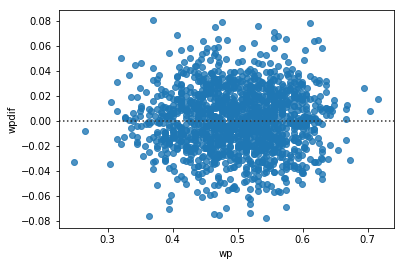

In [182]:
#plot the differences

sns.residplot('wp', 'wpdif', df_james)

For the analysis, I made models based on the entire data set. Next time I will set aside data to test the models on after training other data that the models were built upon. I will still see if I can get the data from the 2016 and 2017 seasons.

In the future, it will be interesting to see how well the random forest regression model predicts win percentage compared to Bill James' Pythagorean Thereom. The model still gives very important insights as to adjustments a team can make in the middle of the season if the organization is looking for a particular winning percentage to perhaps make the postseason. For example, at the trade deadline, an organization could look into acquiring a pitcher that doesn't give up a lot of hits or walks (see Feature Importances above), or a low WHIP (walks and hits per inning pitched); in addition, the team can also look into getting a hitter who hits a lot of homeruns and draws a lot of walks! While it may intuitively seem obvious, now there are numbers to show that these are the four most important features :)